# Calculating Bond Price using Survival Curve

Calculate the bond price using a survival curve.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from financepy.utils import *
from financepy.market.curves import *
from financepy.products.bonds.bond import *

####################################################################
# FINANCEPY BETA Version 0.260 - This build:  22 Nov 2022 at 13:08 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Creating the Bond

In [4]:
issue_date = Date(15, 5, 2010)
maturity_date = Date(15, 5, 2027)
coupon = 0.05
freq_type = FrequencyTypes.SEMI_ANNUAL
accrual_type = DayCountTypes.ACT_ACT_ICMA
face = 100.0 # By setting the face to 100 we expect a price of par to be 100.0

In [5]:
bond = Bond(issue_date, maturity_date, coupon, freq_type, accrual_type, face)

In [6]:
print(bond)

OBJECT TYPE: Bond
ISSUE DATE: 15-MAY-2010
MATURITY DATE: 15-MAY-2027
COUPON (%): 5.0
FREQUENCY: FrequencyTypes.SEMI_ANNUAL
ACCRUAL TYPE: DayCountTypes.ACT_ACT_ICMA
FACE AMOUNT: 100.0


In [7]:
valuation_date = Date(15, 5, 2020)

In [8]:
print(bond.coupon_dates(valuation_date))

 15-MAY-2020         2.50 
 15-NOV-2020         2.50 
 15-MAY-2021         2.50 
 15-NOV-2021         2.50 
 15-MAY-2022         2.50 
 15-NOV-2022         2.50 
 15-MAY-2023         2.50 
 15-NOV-2023         2.50 
 15-MAY-2024         2.50 
 15-NOV-2024         2.50 
 15-MAY-2025         2.50 
 15-NOV-2025         2.50 
 15-MAY-2026         2.50 
 15-NOV-2026         2.50 
 15-MAY-2027       102.50 



## Create a Discount Curve

I create a discount curve with a 5% discount rate.

In [9]:
discCurve = DiscountCurveFlat(valuation_date, 0.05, FrequencyTypes.SEMI_ANNUAL, DayCountTypes.THIRTY_360_BOND)

## Create Survival Curve

I create a curve with a 0% hazard rate, i.e. it is risk free.

In [10]:
h = 0.0

In [11]:
survCurve = DiscountCurveFlat(valuation_date, h)

In [12]:
recovery_rate = 0.0

In [13]:
dirty_price = bond.dirty_price_from_survival_curve(valuation_date, discCurve, survCurve, recovery_rate)

In [14]:
print("DIRTY PRICE: %9.6f" %dirty_price)

DIRTY PRICE: 102.500000


In [15]:
clean_price = bond.clean_price_from_survival_curve(valuation_date, discCurve, survCurve, recovery_rate)

In [16]:
print("CLEAN PRICE: %9.6f" %clean_price)

CLEAN PRICE: 100.000000


The bond prices at par as expected.

## Non-Zero Default Risk

Now I change the hazard rate.

In [17]:
h = 0.02

In [18]:
survCurve = DiscountCurveFlat(valuation_date, h)

In [19]:
clean_price = bond.clean_price_from_survival_curve(valuation_date, discCurve, survCurve, recovery_rate)

In [20]:
print("CLEAN PRICE: %9.6f" %clean_price)

CLEAN PRICE: 88.774861


The bond price falls as it should. Nopw let's make the recovery rate 40%

In [21]:
recovery_rate = 0.40

In [22]:
clean_price = bond.clean_price_from_survival_curve(valuation_date, discCurve, survCurve, recovery_rate)

In [23]:
print("CLEAN PRICE: %9.6f" %clean_price)

CLEAN PRICE: 93.210160


The price increases as more is recovered in default. What if we make the recovery rate 100% ?

In [24]:
recovery_rate = 1.0

In [25]:
clean_price = bond.clean_price_from_survival_curve(valuation_date, discCurve, survCurve, recovery_rate)

In [26]:
print("CLEAN PRICE: %9.6f" %clean_price)

CLEAN PRICE: 99.863108


The price goes up but not to par. This is because a default will still cause coupons to be lost as they are zero recovery.

## Option Adjusted Spread vs Credit Triangle

One measure of credit spread is the OAS. We calculate it.

In [31]:
bond.option_adjusted_spread(valuation_date, clean_price, discCurve) * 10000

2.342586226697817

This is small as the recovery rate is 100%.

Note the credit triangle $S \simeq h (1-R)$ which gives

In [32]:
h * (1.0 - recovery_rate) * 10000

0.0

This is zero as the credit triangle ignores coupons.

Let's check the recovery dependence

In [33]:
recovery_rates = np.linspace(0.0, 1.0, 10)

In [34]:
clean_prices = bond.clean_price_from_survival_curve(valuation_date, discCurve, survCurve, recovery_rates)

In [35]:
optAdjSpds = bond.option_adjusted_spread(valuation_date, clean_prices, discCurve) * 10000

In [36]:
triangleSpds = h * (1-recovery_rates) * 10000

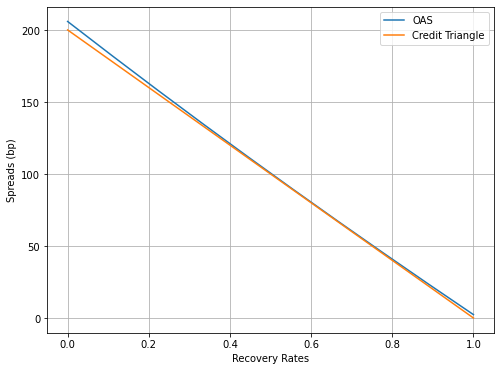

In [37]:
plt.figure(figsize=(8,6))
plt.plot(recovery_rates, optAdjSpds, label="OAS")
plt.plot(recovery_rates, triangleSpds, label="Credit Triangle")
plt.xlabel("Recovery Rates")
plt.ylabel("Spreads (bp)")
plt.grid()
plt.legend()

The credit triangle works well !

Copyright (c) 2020 Dominic O'Kane